In [1]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib
from scipy.signal import lfilter
from scipy import signal
import scipy
import math
from iir_biquad import iir_biquad as iir_biquad_patrick
from iir_biquad import test as test_patrick
from IIRSim import *
from iir_biquad import iir_biquad as patrick_biquad
from iir_biquad import test as patrick_test
from FrequencyResponse import *
from FPGATestIO import *

# Simulation Comparisons

## Biquad Coefficients

### One Time Calculation

In [ ]:
ADDED_PRECISION=0

b, a = signal.iirnotch(350, 2, 3000)
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
pmag=np.abs(pole)
pangle=np.angle(pole)
zmag=np.abs(zero)
zangle=np.angle(zero)

print("a=%s"%a)
print("b=%s"%b)

# Get the coefficients for the quantized biquad
coeffs = iir_biquad_coeffs(pmag, pangle)
coeffs_fixed_point = np.zeros(len(coeffs), dtype=np.int64)
coeffs_fixed_point_signed = np.zeros(len(coeffs), dtype=np.int64)
b_fixed_point_signed = np.zeros(len(b))
a_fixed_point_signed = np.zeros(len(a))

coeffs_fixed_point_extended = np.zeros(len(coeffs), dtype=np.int64)
coeffs_fixed_point_signed_extended = np.zeros(len(coeffs), dtype=np.int64)
b_fixed_point_signed_extended = np.zeros(len(b))
a_fixed_point_signed_extended = np.zeros(len(a))

## Usual Fixed Point
# For transfer function numerator
for i in range(len(b)):
    b_fixed_point_signed[i] = np.floor(b[i] * (2**14))
b_fixed_point_signed = np.array(b_fixed_point_signed, dtype=np.int64)
# Just in case we want to compare these later
# For transfer function denominator, after look-ahead
for i in range(len(a)):
    a_fixed_point_signed[i] = np.floor(a[i] * (2**14))
a_fixed_point_signed = np.array(a_fixed_point_signed, dtype=np.int64)
#  For clustered look-ahead
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point_signed[i] = np.floor(coeffs[i] * (2**14))

coeffs_fixed_point_signed = np.array(coeffs_fixed_point_signed, dtype=np.int64)

## Extended Fixed Point
# For transfer function numerator
for i in range(len(b)):
    b_fixed_point_signed_extended[i] = np.floor(b[i] * (2**(14+ADDED_PRECISION)))
# Just in case we want to compare these later
# For transfer function denominator, after look-ahead
for i in range(len(a)):
    a_fixed_point_signed_extended[i] = np.floor(a[i] * (2**(14+ADDED_PRECISION)))
#  For clustered look-ahead
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point_signed_extended[i] = np.floor(coeffs[i] * (2**(14+ADDED_PRECISION)))

print("a_fixed=%s"%a_fixed_point_signed )
print("b_fixed=%s"%b_fixed_point_signed )

plot_filter_polezero(zmag, zangle, pmag, pangle)

### Biquad Coefficient Write-outs

In [366]:
#notch_freq = 395
# Q_FACTOR = 5
for Q_FACTOR in range(10,500,10):
    print("Q:%s"%Q_FACTOR)
    for notch_freq in range(50,1500,5):
        ADDED_PRECISION=0
        
        b, a = signal.iirnotch(notch_freq, Q_FACTOR, 3000)
        pole = signal.tf2zpk(b,a)[1][0]
        zero = signal.tf2zpk(b,a)[0][0]
        pmag=np.abs(pole)
        pangle=np.angle(pole)
        zmag=np.abs(zero)
        zangle=np.angle(zero)
        
        # Get the coefficients for the quantized biquad
        coeffs = iir_biquad_coeffs(pmag, pangle)
        coeffs_fixed_point = np.zeros(len(coeffs), dtype=np.int64)
        coeffs_fixed_point_signed = np.zeros(len(coeffs), dtype=np.int64)
        b_fixed_point_signed = np.zeros(len(b))
        a_fixed_point_signed = np.zeros(len(a))
        
        coeffs_fixed_point_extended = np.zeros(len(coeffs), dtype=np.int64)
        coeffs_fixed_point_signed_extended = np.zeros(len(coeffs), dtype=np.int64)
        b_fixed_point_signed_extended = np.zeros(len(b))
        a_fixed_point_signed_extended = np.zeros(len(a))
        
        ## Usual Fixed Point
        # For transfer function numerator
        for i in range(len(b)):
            b_fixed_point_signed[i] = np.floor(b[i] * (2**14))
        b_fixed_point_signed = np.array(b_fixed_point_signed, dtype=np.int64)
        # Just in case we want to compare these later
        # For transfer function denominator, after look-ahead
        for i in range(len(a)):
            a_fixed_point_signed[i] = np.floor(a[i] * (2**14))
        a_fixed_point_signed = np.array(a_fixed_point_signed, dtype=np.int64)
        #  For clustered look-ahead
        for i in range(len(coeffs_fixed_point)):
            # Coefficients are in Q4.14, where the sign bit IS counted
            coeffs_fixed_point_signed[i] = np.floor(coeffs[i] * (2**14))
        
        coeffs_fixed_point_signed = np.array(coeffs_fixed_point_signed, dtype=np.int64)
        
        ## Extended Fixed Point
        # For transfer function numerator
        for i in range(len(b)):
            b_fixed_point_signed_extended[i] = np.floor(b[i] * (2**(14+ADDED_PRECISION)))
        # Just in case we want to compare these later
        # For transfer function denominator, after look-ahead
        for i in range(len(a)):
            a_fixed_point_signed_extended[i] = np.floor(a[i] * (2**(14+ADDED_PRECISION)))
        #  For clustered look-ahead
        for i in range(len(coeffs_fixed_point)):
            # Coefficients are in Q4.14, where the sign bit IS counted
            coeffs_fixed_point_signed_extended[i] = np.floor(coeffs[i] * (2**(14+ADDED_PRECISION)))
    
        
        samp_per_clock=8
        f_fir = coeffs_fixed_point_signed[0:samp_per_clock-2]
        g_fir = coeffs_fixed_point_signed[samp_per_clock-2:2*samp_per_clock-3]
        D_FF = coeffs_fixed_point_signed[2*samp_per_clock-3 + 0]
        D_FG = coeffs_fixed_point_signed[2*samp_per_clock-3 + 1]
        E_GF = coeffs_fixed_point_signed[2*samp_per_clock-3 + 2]
        E_GG = coeffs_fixed_point_signed[2*samp_per_clock-3 + 3]
        C = coeffs_fixed_point_signed[2*samp_per_clock-3 + 4:2*samp_per_clock-3 + 4 + 4]
    
        
        with open("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(notch_freq,Q_FACTOR),"w") as coeff_file:
            coeff_file.write("%d\n"%(int(b_fixed_point_signed[1])))# B
            coeff_file.write("%d\n"%(int(b_fixed_point_signed[0])))# A
    
            coeff_file.write("%d\n"%(int(C[2])))# C2
            coeff_file.write("%d\n"%(int(C[3])))# C3
            coeff_file.write("%d\n"%(int(C[1])))# C1
            coeff_file.write("%d\n"%(int(C[0])))# C0
    
            coeff_file.write("%d\n"%(int(a_fixed_point_signed[2])))# a2'
            coeff_file.write("%d\n"%(int(a_fixed_point_signed[1])))# a1'        
    
            coeff_file.write("%d\n"%(int(D_FF)))# D_FF
            coeff_file.write("%d\n"%(int(f_fir[5])))# X6
            coeff_file.write("%d\n"%(int(f_fir[4])))# X5
            coeff_file.write("%d\n"%(int(f_fir[3])))# X4
            coeff_file.write("%d\n"%(int(f_fir[2])))# X3
            coeff_file.write("%d\n"%(int(f_fir[1])))# X2
            coeff_file.write("%d\n"%(int(f_fir[0])))# X1
    
            coeff_file.write("%d\n"%(int(E_GG)))# E_GG
            coeff_file.write("%d\n"%(int(g_fir[6])))# X7
            coeff_file.write("%d\n"%(int(g_fir[5])))# X6
            coeff_file.write("%d\n"%(int(g_fir[4])))# X5
            coeff_file.write("%d\n"%(int(g_fir[3])))# X4
            coeff_file.write("%d\n"%(int(g_fir[2])))# X3
            coeff_file.write("%d\n"%(int(g_fir[1])))# X2
            coeff_file.write("%d\n"%(int(g_fir[0])))# X1
            
            coeff_file.write("%d\n"%(int(D_FG)))# D_FG
            
            coeff_file.write("%d\n"%(int(E_GF)))# E_GF
    
            for a_i in a_fixed_point_signed:
                coeff_file.write("%d\n"%(int(a_i)))
            for b_i in b_fixed_point_signed:
                coeff_file.write("%d\n"%(int(b_i)))

Q:10
Q:20
Q:30
Q:40
Q:50
Q:60
Q:70
Q:80
Q:90
Q:100
Q:110
Q:120
Q:130
Q:140
Q:150
Q:160
Q:170
Q:180
Q:190
Q:200
Q:210
Q:220
Q:230
Q:240
Q:250
Q:260


KeyboardInterrupt: 

### Biquad Coefficient Read-Ins

In [2]:
def get_coeffs(filename):
    # notch_freq = 350
    # Q_FACTOR = 5
    
    # Assuming 8 samples per clock
    samp_per_clock=8
    coeffs_fixed_point_signed = np.zeros(2*samp_per_clock-3 + 4 + 4, dtype=np.int64) # 21
    b_fixed_point_signed = np.zeros(3, dtype=np.int64)
    a_fixed_point_signed = np.zeros(3, dtype=np.int64)
    b_fixed_point_signed_all = np.zeros(3, dtype=np.int64)
    a_fixed_point_signed_all = np.zeros(3, dtype=np.int64)
    C = np.zeros(4)
    f_fir = np.zeros(6)
    g_fir = np.zeros(7)
    
    #with open("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(notch_freq,Q_FACTOR),"r") as coeff_file:
    with open(filename,"r") as coeff_file:
        coeff_list = []
        for line in coeff_file:
            coeff_value = int(line.strip())
            coeff_list.append(coeff_value)
        
    b_fixed_point_signed[1] = coeff_list[0] # B
    b_fixed_point_signed[0] = coeff_list[1] # A
    b_fixed_point_signed[2] = coeff_list[1] # A (again, we assume)
    
    C[2] = coeff_list[2]#coeff_file.write("%d\n"%(int(C[2])))# C2
    C[3] = coeff_list[3]#coeff_file.write("%d\n"%(int(C[3])))# C3
    C[1] = coeff_list[4]#coeff_file.write("%d\n"%(int(C[1])))# C1
    C[0] = coeff_list[5]#coeff_file.write("%d\n"%(int(C[0])))# C0
    
    a_fixed_point_signed[2] = coeff_list[6]#coeff_file.write("%d\n"%(int(a_fixed_point_signed[2])))# a2'
    a_fixed_point_signed[1] = coeff_list[7]#coeff_file.write("%d\n"%(int(a_fixed_point_signed[1])))# a1'        
    
    D_FF = coeff_list[8]#coeff_file.write("%d\n"%(int(D_FF)))# D_FF
    f_fir[5] = coeff_list[9]# X6
    f_fir[4] = coeff_list[10]# X5
    f_fir[3] = coeff_list[11]# X4
    f_fir[2] = coeff_list[12]# X3
    f_fir[1] = coeff_list[13]# X2
    f_fir[0] = coeff_list[14]# X1
    
    E_GG = coeff_list[15]# E_GG
    g_fir[6] = coeff_list[16]# X7
    g_fir[5] = coeff_list[17]# X6
    g_fir[4] = coeff_list[18]# X5
    g_fir[3] = coeff_list[19]# X4
    g_fir[2] = coeff_list[20]# X3
    g_fir[1] = coeff_list[21]# X2
    g_fir[0] = coeff_list[22]# X1
    
    D_FG = coeff_list[23] # D_FG
    
    E_GF = coeff_list[24] # E_GF
    
    a_fixed_point_signed_all[0] = coeff_list[25]
    a_fixed_point_signed_all[1] = coeff_list[26]
    a_fixed_point_signed_all[2] = coeff_list[27]
    b_fixed_point_signed_all[0] = coeff_list[28]
    b_fixed_point_signed_all[1] = coeff_list[29]
    b_fixed_point_signed_all[2] = coeff_list[30]
    
    coeffs_fixed_point_signed[0:samp_per_clock-2] = f_fir
    coeffs_fixed_point_signed[samp_per_clock-2:2*samp_per_clock-3] = g_fir
    coeffs_fixed_point_signed[2*samp_per_clock-3 + 0] = D_FF
    coeffs_fixed_point_signed[2*samp_per_clock-3 + 1] = D_FG
    coeffs_fixed_point_signed[2*samp_per_clock-3 + 2] = E_GF
    coeffs_fixed_point_signed[2*samp_per_clock-3 + 3] = E_GG
    coeffs_fixed_point_signed[2*samp_per_clock-3 + 4:2*samp_per_clock-3 + 4 + 4] = C
    return coeffs_fixed_point_signed, a_fixed_point_signed_all, b_fixed_point_signed_all

## Individual Responses

### Impulse Response

In [11]:
pulse_from_file = import_data("001_files/inputs/pulse_input_height_1024_clipped.dat")

In [12]:
notch_freq = 350
Q_FACTOR = 3
b, a = signal.iirnotch(notch_freq,Q_FACTOR, 3000)
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
pmag=np.abs(pole)
pangle=np.angle(pole)
zmag=np.abs(zero)
zangle=np.angle(zero)

In [13]:
coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(notch_freq,Q_FACTOR))


****


****



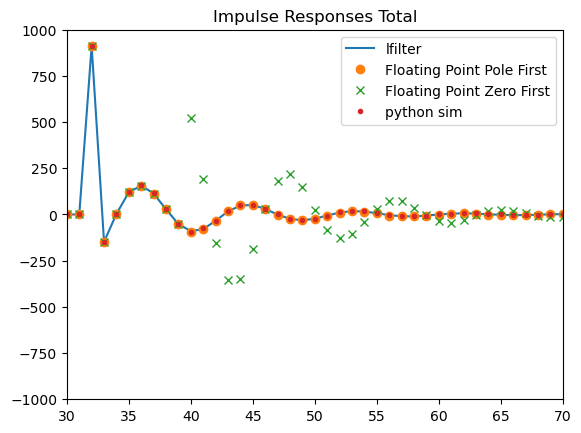

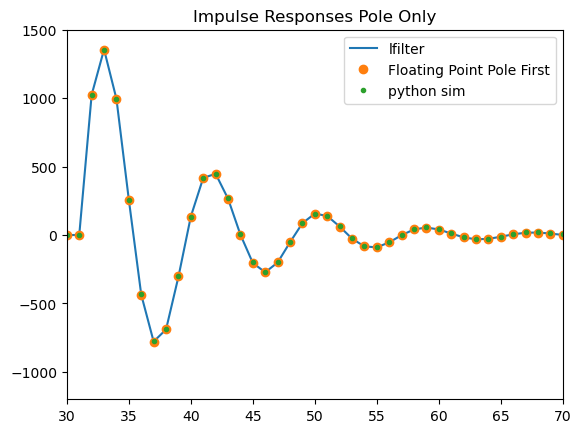

912.0182407714393
912


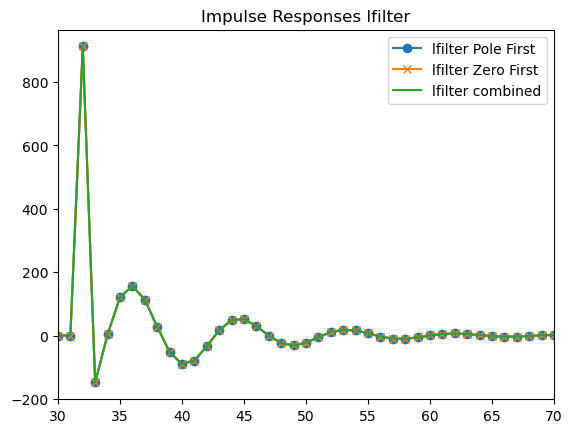

In [14]:
DEBUG=0
pulse_from_file_FIR = lfilter(b,[1],pulse_from_file.copy())
lfilter_data_zero_first = lfilter([1],a,np.array(pulse_from_file_FIR))#lfilter(b,a,np.array(pulse_from_file))



pulse_from_file_IIR = lfilter([1],a,pulse_from_file.copy())
lfilter_data_pole_first = lfilter(b,[1],np.array(pulse_from_file_IIR))#lfilter(b,a,np.array(pulse_from_file))

lfilter_data = lfilter(b,a,pulse_from_file.copy())#lfilter(b,a,np.array(pulse_from_file))

patrick_data = lfilter(b,[1],patrick_biquad(pulse_from_file.copy(), 8, pmag, pangle, ics = None, debug=DEBUG).copy())
patrick_data_reversed = patrick_biquad(lfilter(b,[1],pulse_from_file.copy()).copy(), 8, pmag, pangle, ics = None, debug=DEBUG)

patrick_IIR = patrick_biquad(pulse_from_file.copy(), 8, pmag, pangle, ics = None, debug=DEBUG)

# patrick_data = patrick_biquad(pulse_from_file_FIR, 8, pmag, pangle, ics = None, debug=1)

# patrick_data_reverse = patrick_biquad(pulse_from_file, 8, pmag, pangle, ics = None, debug=1)
# patrick_data_reverse = lfilter(b,[1],patrick_data_reverse)


print("\n****\n")
# The "a"s are now being quantized
python_data_IIR = iir_biquad_run_fixed_point(pulse_from_file.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)
print("\n****\n")
# # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
# values_with_FIR_extended = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed_extended, [1], pulse_from_file)),dtype=np.int64),
#                                           14+ADDED_PRECISION)
# The "a"s being used are not quantized, they are processed as floating point
# python_data_extended = iir_biquad_run_fixed_point_extended(pulse_from_file.copy(), coeffs_fixed_point_signed_extended, 
#                                                              decimate=True, a1=a[1], a2=a[0],debug=DEBUG, added_precision=ADDED_PRECISION) 
# python_data_extended = lfilter(b,[1],python_data_extended.copy())

# print("\n****\n")
# # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
# values_with_FIR = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed, [1], pulse_from_file)),dtype=np.int64),14)
# # The "a"s being used are not quantized, they are processed as floating point
# python_data = iir_biquad_run_fixed_point(np.array(values_with_FIR), coeffs_fixed_point_signed, 
#                                          decimate=True, a1=a[1], a2=a[0],debug=1) 

# print("\n****\n")
# # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
# values_with_FIR_extended = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed_extended, [1], pulse_from_file)),dtype=np.int64),
#                                           14+ADDED_PRECISION)
# # The "a"s being used are not quantized, they are processed as floating point
# python_data_extended = iir_biquad_run_fixed_point_extended(np.array(values_with_FIR_extended), coeffs_fixed_point_signed_extended, 
#                                                              decimate=True, a1=a[1], a2=a[0],debug=1, added_precision=ADDED_PRECISION) 

# plt.plot(range(len(pulse_from_file)), lfilter_data_reversed, label="lfilter Pole First", linestyle="--")
plt.plot(range(len(pulse_from_file)), lfilter_data, label="lfilter", linestyle="-")

plt.plot(range(len(pulse_from_file)), patrick_data, label="Floating Point Pole First", marker="o", linestyle="None")
plt.plot(range(len(pulse_from_file)), patrick_data_reversed, label="Floating Point Zero First", marker="x", linestyle="None")

# plt.plot(range(len(pulse_from_file)), patrick_data_combined, label="Patrick Sim Combined", marker="x")
# plt.plot(range(len(pulse_from_file)), lfilter_data_reversed, label="lfilter Pole First", linestyle=":")
# plt.plot(range(len(pulse_from_file)), python_data, label="python sim", linestyle="None", marker="o")
plt.plot(range(len(pulse_from_file)), python_data, label="python sim", linestyle="None", marker=".")
plt.legend()
plt.title("Impulse Responses Total")
plt.xlim(30,70)
plt.ylim(-1000,1000)
plt.show()


plt.plot(range(len(pulse_from_file)), pulse_from_file_IIR, label="lfilter", linestyle="-")

plt.plot(range(len(pulse_from_file)), patrick_IIR, label="Floating Point Pole First", marker="o", linestyle="None")
# plt.plot(range(len(pulse_from_file)), patrick_data_reversed, label="Floating Point Zero First", marker="x", linestyle="None")

# plt.plot(range(len(pulse_from_file)), patrick_data_combined, label="Patrick Sim Combined", marker="x")
# plt.plot(range(len(pulse_from_file)), lfilter_data_reversed, label="lfilter Pole First", linestyle=":")
# plt.plot(range(len(pulse_from_file)), python_data, label="python sim", linestyle="None", marker="o")
plt.plot(range(len(pulse_from_file)), python_data_IIR, label="python sim", linestyle="None", marker=".")
plt.legend()
plt.title("Impulse Responses Pole Only")
plt.xlim(30,70)
plt.ylim(-1200,1500)
plt.show()
print(lfilter_data[32])
print(python_data[32])

# plt.plot(range(len(pulse_from_file)), np.subtract(patrick_data,lfilter_data ), label="simulation difference")
# plt.title("Patrick Tone Response Difference")
# plt.show()

# plt.plot(range(len(pulse_from_file)), np.subtract(python_data,lfilter_data ), label="python simulation difference")
# plt.title("Python Tone Response Difference")
# plt.legend()
# plt.xlim(0,500)
# plt.title("Impulse Responses")
# plt.show()

# plt.plot(range(len(pulse_from_file)), np.subtract(patrick_data,lfilter_data ), label="patrick simulation difference")
# plt.title("Impulse Response Difference")
# plt.xlim(0,500)
# plt.show()


# plt.plot(range(len(pulse_from_file)), np.subtract(patrick_data,python_data ), label="both simulation difference")
# plt.title("Impulse Response Difference")
# plt.xlim(0,500)
# plt.show()

plt.plot(range(len(pulse_from_file)), lfilter_data_pole_first, label="lfilter Pole First", marker="o")
plt.plot(range(len(pulse_from_file)), lfilter_data_zero_first, label="lfilter Zero First", marker="x")
plt.plot(range(len(pulse_from_file)), lfilter_data, label="lfilter combined")

plt.legend()
plt.title("Impulse Responses lfilter")
plt.xlim(30,70)
# plt.ylim(-1000,1000)
plt.show()


### Tone Response

In [15]:
tone_from_file = import_data("001_files/inputs/input_200_MHz_4_zpclocks_hanning.dat")

In [16]:
notch_freq = 350
Q_FACTOR = 3
b, a = signal.iirnotch(notch_freq,Q_FACTOR, 3000)
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
pmag=np.abs(pole)
pangle=np.angle(pole)
zmag=np.abs(zero)
zangle=np.angle(zero)

In [17]:
coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(notch_freq,Q_FACTOR))

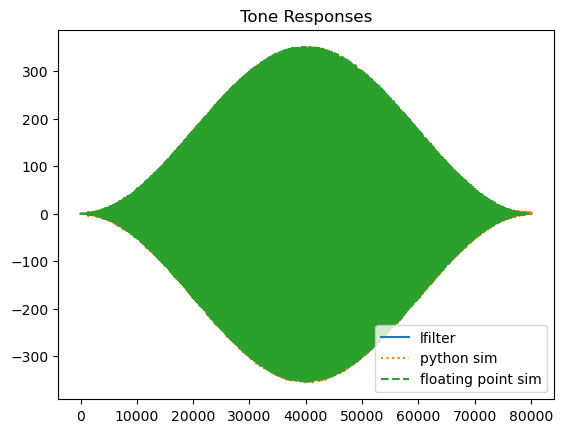

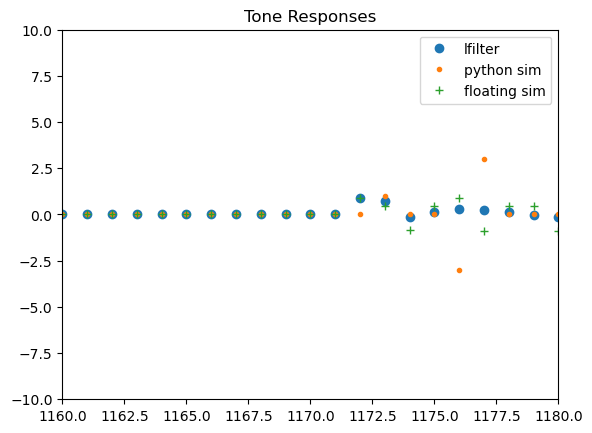

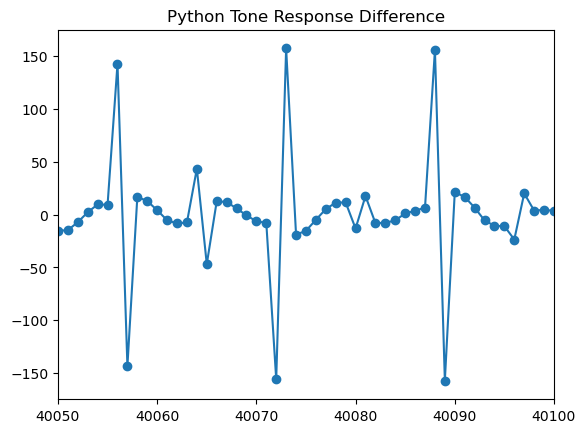

In [18]:
# patrick_data = lfilter(b,[1],patrick_biquad(tone_from_file, 8, pmag, pangle, ics = None))
# lfilter_data = lfilter(b,a,np.array(tone_from_file))

lfilter_data = lfilter(b,a,tone_from_file.copy())#lfilter(b,a,np.array(pulse_from_file))

# The "a"s being used are not quantized, they are processed as floating point

patrick_data = lfilter(b,[1],patrick_biquad(tone_from_file.copy(), 8, pmag, pangle, ics = None, debug=DEBUG).copy())

python_data_IIR = iir_biquad_run_fixed_point(tone_from_file.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)

# # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
# values_with_FIR = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed, [1], tone_from_file)),dtype=np.int64),14)

# # The "a"s being used are not quantized, they are processed as floating point
# python_data = iir_biquad_run_fixed_point(np.array(values_with_FIR), coeffs_fixed_point_signed, 
#                                          decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=0) 

# plt.plot(range(len(tone_from_file)), patrick_data, label="Patrick Sim")
plt.plot(range(len(tone_from_file)), lfilter_data, label="lfilter", linestyle="-")
plt.plot(range(len(tone_from_file)), python_data, label="python sim", linestyle=":")
plt.plot(range(len(tone_from_file)), patrick_data, label="floating point sim", linestyle="--")
plt.legend()
plt.title("Tone Responses")
# plt.xlim(40000,40100)
plt.show()

plt.plot(range(len(tone_from_file)), lfilter_data, label="lfilter", linestyle="None", marker="o")
plt.plot(range(len(tone_from_file)), python_data, label="python sim", linestyle="None", marker=".")
plt.plot(range(len(tone_from_file)), patrick_data, label="floating sim", linestyle="None", marker="+")
plt.legend()
plt.title("Tone Responses")
# plt.xlim(40050,40100)
plt.xlim(1160,1180)
plt.ylim(-10,10)
plt.show()

# plt.plot(range(len(pulse_from_file)), np.subtract(patrick_data,lfilter_data ), label="simulation difference")
# plt.title("Patrick Tone Response Difference")
# plt.show()

plt.plot(range(len(tone_from_file)), np.subtract(python_data,lfilter_data ), label="simulation difference", marker="o")
plt.title("Python Tone Response Difference")
plt.xlim(40050,40100)
plt.show()

### Gaussian Noise Response

In [19]:
gauss_from_file = import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_0.dat")

In [20]:
notch_freq = 350
Q_FACTOR = 3
b, a = signal.iirnotch(notch_freq,Q_FACTOR, 3000)
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
pmag=np.abs(pole)
pangle=np.angle(pole)
zmag=np.abs(zero)
zangle=np.angle(zero)

In [21]:
coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(notch_freq,Q_FACTOR))

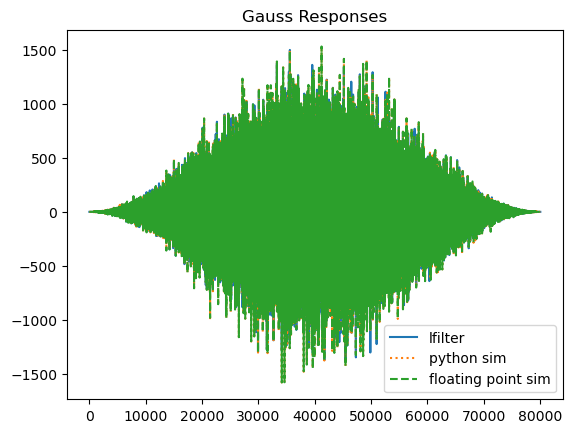

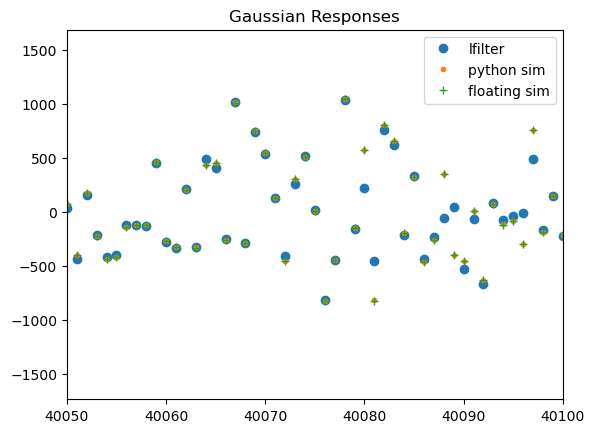

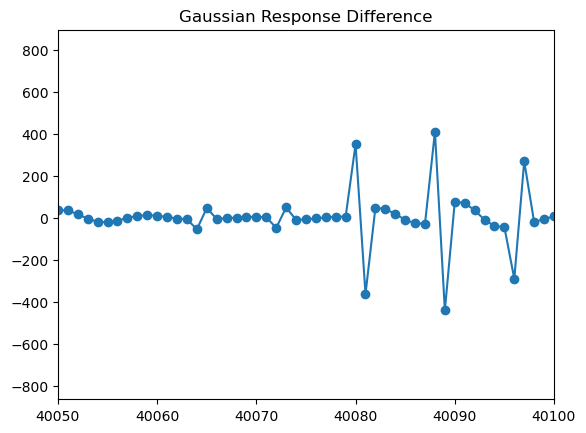

In [22]:
# patrick_data = lfilter(b,[1],patrick_biquad(gauss_from_file, 8, pmag, pangle, ics = None))
# lfilter_data = lfilter(b,a,np.array(gauss_from_file))

lfilter_data = lfilter(b,a,gauss_from_file.copy())#lfilter(b,a,np.array(pulse_from_file))

# The "a"s being used are not quantized, they are processed as floating point

patrick_data = lfilter(b,[1],patrick_biquad(gauss_from_file.copy(), 8, pmag, pangle, ics = None, debug=DEBUG).copy())

python_data_IIR = iir_biquad_run_fixed_point(gauss_from_file.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)

# # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
# values_with_FIR = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed, [1], gauss_from_file)),dtype=np.int64),14)

# # The "a"s being used are not quantized, they are processed as floating point
# python_data = iir_biquad_run_fixed_point(np.array(values_with_FIR), coeffs_fixed_point_signed, 
#                                          decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=0) 

# plt.plot(range(len(gauss_from_file)), patrick_data, label="Patrick Sim")
plt.plot(range(len(gauss_from_file)), lfilter_data, label="lfilter", linestyle="-")
plt.plot(range(len(gauss_from_file)), python_data, label="python sim", linestyle=":")
plt.plot(range(len(gauss_from_file)), patrick_data, label="floating point sim", linestyle="--")
plt.legend()
plt.title("Gauss Responses")
# plt.xlim(40000,40100)
plt.show()

plt.plot(range(len(gauss_from_file)), lfilter_data, label="lfilter", linestyle="None", marker="o")
plt.plot(range(len(gauss_from_file)), python_data, label="python sim", linestyle="None", marker=".")
plt.plot(range(len(gauss_from_file)), patrick_data, label="floating sim", linestyle="None", marker="+")
plt.legend()
plt.title("Gaussian Responses")
plt.xlim(40050,40100)
plt.show()

# plt.plot(range(len(pulse_from_file)), np.subtract(patrick_data,lfilter_data ), label="simulation difference")
# plt.title("Patrick gauss Response Difference")
# plt.show()

plt.plot(range(len(gauss_from_file)), np.subtract(python_data,lfilter_data), label="simulation difference", marker="o")
plt.title("Gaussian Response Difference")
plt.xlim(40050,40100)
plt.show()

## Frequency Response Using Gaussians

In [373]:
fft_input_result = {}
fft_patrick_result = {}
fft_lfilter_result = {}
fft_python_result = {}

In [374]:
TRIALS = 100
NOTCH = 300
Q_FACTOR = 30

b, a = signal.iirnotch(NOTCH,Q_FACTOR, 3000)
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
pmag=np.abs(pole)
pangle=np.angle(pole)
zmag=np.abs(zero)
zangle=np.angle(zero)

coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(NOTCH,Q_FACTOR))

# Import the Gaussian input data once to get the lengths
data_len = len(import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%0))
fft_input_results = np.zeros((TRIALS, data_len))     
fft_patrick_results = np.zeros((TRIALS, data_len))     
fft_python_results = np.zeros((TRIALS, data_len))   
fft_lfilter_results = np.zeros((TRIALS, data_len))

# Run the trials on the data
for i in range(TRIALS):
    # Import the trial inputs
    gauss_samps = import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%i)

    # Run the filters on the trials
    patrick_data = lfilter(b,[1],patrick_biquad(gauss_samps.copy(), 8, pmag, pangle, ics = None))
    lfilter_data = lfilter(b,a,gauss_samps)

    python_data_IIR = iir_biquad_run_fixed_point(gauss_samps.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
    python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)

    # # The "a"s being used are not quantized, they are processed as floating point
    # python_data_iir = iir_biquad_run_fixed_point(gauss_samps.copy(), coeffs_fixed_point_signed, 
    #                                          decimate=False, a1=a[1], a2=a[2],debug=0) 

    
    # # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
    # python_data = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed, [1], python_data_iir)),dtype=np.int64),14)
    
    fft_input_results[i] = np.abs(np.fft.fft(gauss_samps))**2   
    fft_patrick_results[i] = np.abs(np.fft.fft(patrick_data))**2
    fft_lfilter_results[i] = np.abs(np.fft.fft(lfilter_data))**2
    fft_python_results[i] = np.abs(np.fft.fft(python_data))**2
    if(i%10 == 0):
        print(i)
fft_input_result[NOTCH] = np.mean(fft_input_results, axis=0)
fft_patrick_result[NOTCH] = np.mean(fft_patrick_results, axis=0)
fft_lfilter_result[NOTCH] = np.mean(fft_lfilter_results, axis=0)
fft_python_result[NOTCH] = np.mean(fft_python_results, axis=0)

0
10
20
30
40
50
60
70
80
90


In [375]:
fft_lfilter_result.keys()

dict_keys([300])

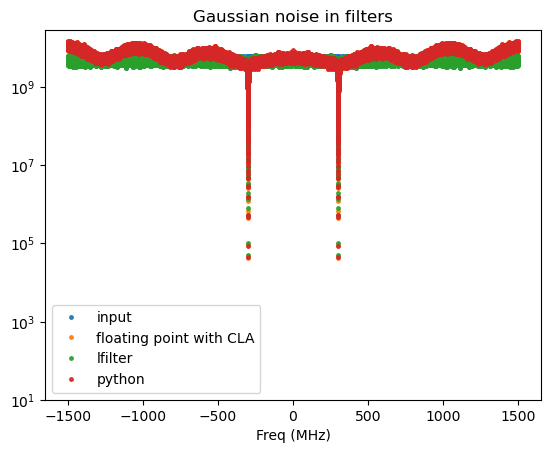

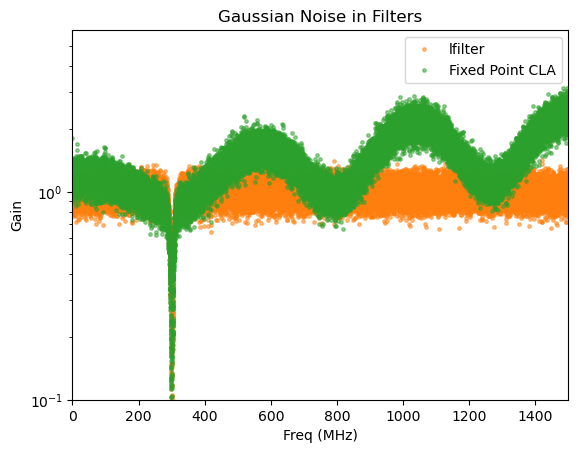

In [377]:
plot_notch_freq = 300
plot_sample_freq=3000
plt.plot(plot_sample_freq*np.fft.fftfreq(len(fft_input_result[plot_notch_freq])),np.abs(fft_input_result[plot_notch_freq]), linestyle="None", 
         marker=".", label="input", markersize=5, alpha=0.9, color="C0")
plt.plot(plot_sample_freq*np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq]), linestyle="None", 
         marker=".", label="floating point with CLA", markersize=5, alpha=0.9, color="C1")
plt.plot(plot_sample_freq*np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq])),np.abs(fft_lfilter_result[plot_notch_freq]), linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.9, color="C2")
plt.plot(plot_sample_freq*np.fft.fftfreq(len(fft_python_result[plot_notch_freq])),np.abs(fft_python_result[plot_notch_freq]), linestyle="None",
         marker=".", label="python", markersize=5, alpha=0.9, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**1)
plt.title("Gaussian noise in filters")
# plt.xlim(0,0.5)
# plt.savefig("GaussianNoiseOn%dMHzNotch.png"%plot_notch_freq)
if(plot_sample_freq > 1):
    plt.xlabel("Freq (MHz)")
else:
    plt.xlabel("Frequency/(Sampling Frequency)")
plt.show()

mean_power = np.mean(fft_input_result[plot_notch_freq])


# plt.plot(np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq])/mean_power, linestyle="None", 
#          marker=".", label="floating point with CLA", markersize=1, alpha=0.05, color="C1")
plt.plot(plot_sample_freq*np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq])),np.abs(fft_lfilter_result[plot_notch_freq])/mean_power, linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.5, color="C1")
plt.plot(plot_sample_freq*np.fft.fftfreq(len(fft_python_result[plot_notch_freq])),np.abs(fft_python_result[plot_notch_freq])/mean_power, linestyle="None",
         marker=".", label="Fixed Point CLA", markersize=5, alpha=0.5, color="C2")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**-1)
plt.title("Gaussian Noise in Filters")
plt.xlim(plot_sample_freq*0,plot_sample_freq*0.5)
if(plot_sample_freq > 1):
    plt.xlabel("Freq (MHz)")
else:
    plt.xlabel("Frequency/(Sampling Frequency)")
plt.ylabel("Gain")
# plt.savefig("GaussianNoiseOn%dMHzNotch.png"%plot_notch_freq)
plt.show()

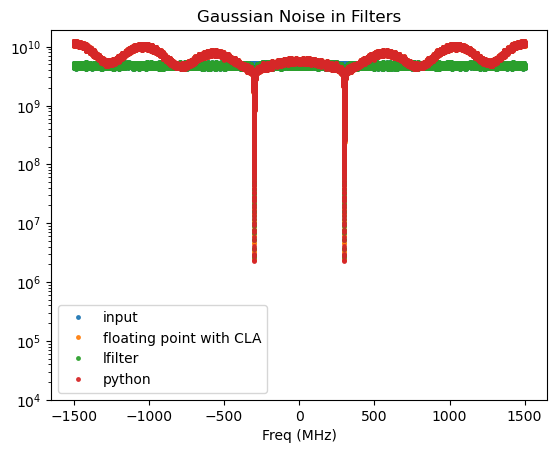

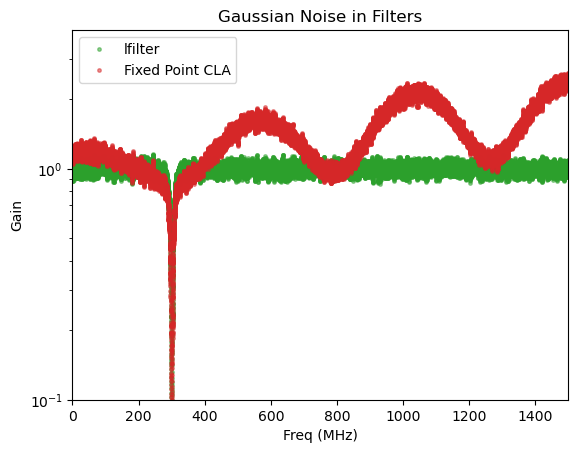

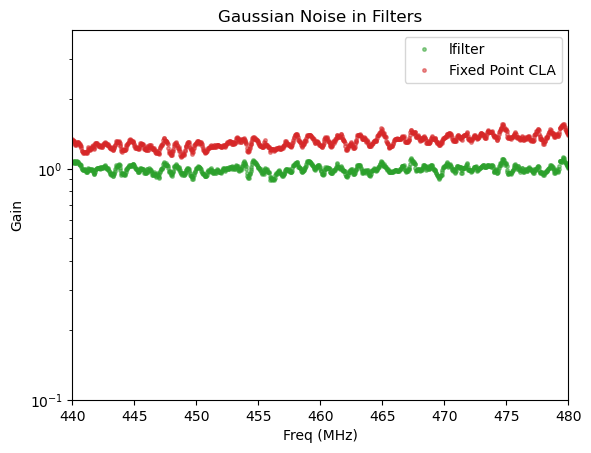

In [378]:
N=11

plot_freqs = plot_sample_freq*np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq]))[int(np.floor(N/2.0)):int(-np.floor(N/2.0))]

plot_notch_freq = 300
plt.plot(plot_freqs,np.convolve(np.abs(fft_input_result[plot_notch_freq]), np.ones(N)/N, mode='valid'), linestyle="None", 
         marker=".", label="input", markersize=5, alpha=0.9, color="C0")
plt.plot(plot_freqs,np.convolve(np.abs(fft_patrick_result[plot_notch_freq]), np.ones(N)/N, mode='valid'), linestyle="None", 
         marker=".", label="floating point with CLA", markersize=5, alpha=0.9, color="C1")
plt.plot(plot_freqs,np.convolve(np.abs(fft_lfilter_result[plot_notch_freq]), np.ones(N)/N, mode='valid'), linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.9, color="C2")
plt.plot(plot_freqs,np.convolve(np.abs(fft_python_result[plot_notch_freq]), np.ones(N)/N, mode='valid'), linestyle="None",
         marker=".", label="python", markersize=5, alpha=0.9, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**4)
plt.title("Gaussian Noise in Filters")
# plt.xlim(0,0.5)
# plt.savefig("GaussianNoiseOn%dMHzNotch.png"%plot_notch_freq)
if(plot_sample_freq > 1):
    plt.xlabel("Freq (MHz)")
else:
    plt.xlabel("Frequency/(Sampling Frequency)")
plt.show()

mean_power = np.mean(fft_input_result[plot_notch_freq])


# plt.plot(np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq])/mean_power, linestyle="None", 
#          marker=".", label="floating point with CLA", markersize=1, alpha=0.05, color="C1")
plt.plot(plot_freqs,np.convolve(np.abs(fft_lfilter_result[plot_notch_freq]), np.ones(N)/N, mode='valid')/mean_power, linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.5, color="C2")
plt.plot(plot_freqs,np.convolve(np.abs(fft_python_result[plot_notch_freq]), np.ones(N)/N, mode='valid')/mean_power, linestyle="None",
         marker=".", label="Fixed Point CLA", markersize=5, alpha=0.5, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**-1)
plt.title("Gaussian Noise in Filters")
plt.xlim(plot_sample_freq*0,plot_sample_freq*0.5)
if(plot_sample_freq > 1):
    plt.xlabel("Freq (MHz)")
else:
    plt.xlabel("Frequency/(Sampling Frequency)")
plt.ylabel("Gain")
plt.savefig("GaussianNotch_%sMHz.png"%plot_notch_freq)
# plt.savefig("GaussianNoiseOn%dMHzNotch.png"%plot_notch_freq)
plt.show()

# plt.plot(np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq])/mean_power, linestyle="None", 
#          marker=".", label="floating point with CLA", markersize=1, alpha=0.05, color="C1")
plt.plot(plot_freqs,np.convolve(np.abs(fft_lfilter_result[plot_notch_freq]), np.ones(N)/N, mode='valid')/mean_power, linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.5, color="C2")
plt.plot(plot_freqs,np.convolve(np.abs(fft_python_result[plot_notch_freq]), np.ones(N)/N, mode='valid')/mean_power, linestyle="None",
         marker=".", label="Fixed Point CLA", markersize=5, alpha=0.5, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**-1)
plt.title("Gaussian Noise in Filters")
plt.xlim(440,480)
if(plot_sample_freq > 1):
    plt.xlabel("Freq (MHz)")
else:
    plt.xlabel("Frequency/(Sampling Frequency)")
plt.ylabel("Gain")
plt.savefig("GaussianNotchZoom_%sMHz.png"%plot_notch_freq)
plt.show()

### Extended Precision, rounding coeffs

In [ ]:
fft_input_result = {}
fft_patrick_result = {}
fft_lfilter_result = {}
fft_python_result = {}

In [ ]:
TRIALS = 50
NOTCH = 750
Q = 1
ADDED_PRECISION=10

# Get the parameters of the notch
b, a = signal.iirnotch(NOTCH, Q, 3000)
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
pmag=np.abs(pole)
pangle=np.angle(pole)
zmag=np.abs(zero)
zangle=np.angle(zero)

# Get the coefficients for the quantized biquad
coeffs = iir_biquad_coeffs(pmag, pangle)
coeffs_fixed_point = np.zeros(len(coeffs), dtype=np.int64)
coeffs_fixed_point_signed = np.zeros(len(coeffs), dtype=np.int64)
b_fixed_point_signed = np.zeros(len(b))

# For transfer function numerator
for i in range(len(b)):
    b_fixed_point_signed[i] = np.array(np.floor(b[i] * (2**(14+ADDED_PRECISION))),dtype=np.int64)
# Just in case we want to compare these later
a_fixed_point_signed = np.zeros(len(a))
# For transfer function denominator, after look-ahead
for i in range(len(a)):
    a_fixed_point_signed[i] = np.array(np.floor(a[i] * (2**(14+ADDED_PRECISION))),dtype=np.int64)
#  For clustered look-ahead
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point_signed[i] = np.array(np.floor(coeffs[i] * (2**(14+ADDED_PRECISION))),dtype=np.int64)

# Import the Gaussian input data once to get the lengths
data_len = len(import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%0))
fft_input_results = np.zeros((TRIALS, data_len))     
fft_patrick_results = np.zeros((TRIALS, data_len))     
fft_python_results = np.zeros((TRIALS, data_len))   
fft_lfilter_results = np.zeros((TRIALS, data_len))

# Run the trials on the data
for i in range(TRIALS):
    # Import the trial inputs
    gauss_samps = import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%i)

    # Run the filters on the trials
    patrick_data = lfilter(b,[1],patrick_biquad(gauss_samps, 8, pmag, pangle, ics = None))
    lfilter_data = lfilter(b,a,gauss_samps)

    # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
    values_with_FIR = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed, [1], gauss_samps)),dtype=np.int64),(14+ADDED_PRECISION))

    # The "a"s being used are not quantized, they are processed as floating point
    python_data = iir_biquad_run_fixed_point_extended(np.array(values_with_FIR), coeffs_fixed_point_signed, 
                                             decimate=False, a1=a[1], a2=a[1],debug=0) 
    
    fft_input_results[i] = np.abs(np.fft.fft(gauss_samps))**2   
    fft_patrick_results[i] = np.abs(np.fft.fft(patrick_data))**2
    fft_lfilter_results[i] = np.abs(np.fft.fft(lfilter_data))**2
    fft_python_results[i] = np.abs(np.fft.fft(python_data))**2
    if(i%10 == 0):
        print(i)
fft_input_result[NOTCH] = np.mean(fft_input_results, axis=0)
fft_patrick_result[NOTCH] = np.mean(fft_patrick_results, axis=0)
fft_lfilter_result[NOTCH] = np.mean(fft_lfilter_results, axis=0)
fft_python_result[NOTCH] = np.mean(fft_python_results, axis=0)

In [ ]:
plot_notch_freq = 750
plt.plot(np.fft.fftfreq(len(fft_input_result[plot_notch_freq])),np.abs(fft_input_result[plot_notch_freq]), linestyle="None", 
         marker=".", label="input", markersize=5, alpha=0.9, color="C0")
plt.plot(np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq]), linestyle="None", 
         marker=".", label="floating point with CLA", markersize=5, alpha=0.9, color="C1")
plt.plot(np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq])),np.abs(fft_lfilter_result[plot_notch_freq]), linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.9, color="C2")
plt.plot(np.fft.fftfreq(len(fft_python_result[plot_notch_freq])),np.abs(fft_python_result[plot_notch_freq]), linestyle="None",
         marker=".", label="python", markersize=5, alpha=0.9, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**8)
plt.title("Gaussian noise in filters")
# plt.xlim(0,0.5)
# plt.savefig("GaussianNoiseOn%dMHzNotch.png"%plot_notch_freq)
plt.show()

mean_power = np.mean(fft_input_result[plot_notch_freq])


plt.plot(np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq])/mean_power, linestyle="None", 
         marker=".", label="floating point with CLA", markersize=5, alpha=0.9, color="C1")
plt.plot(np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq])),np.abs(fft_lfilter_result[plot_notch_freq])/mean_power, linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.9, color="C2")
plt.plot(np.fft.fftfreq(len(fft_python_result[plot_notch_freq])),np.abs(fft_python_result[plot_notch_freq])/mean_power, linestyle="None",
         marker=".", label="python", markersize=5, alpha=0.9, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**-5)
plt.title("Gaussian noise in filters")
plt.xlim(0,0.5)
plt.xlabel("Frequency/(Sampling Frequency)")
plt.ylabel("Gain")
# plt.savefig("GaussianNoiseOn%dMHzNotch.png"%plot_notch_freq)
plt.show()

## Verilog Testing

### With Zero

In [181]:
TRIALS = 1
NOTCH = 800
Q_FACTOR = 8



verilog_nominal_latency = 136
verilog_data_decimated = {}
verilog_data_decimated[Q_FACTOR] = {}
verilog_data_decimated[Q_FACTOR][NOTCH] = []
for trial in range(TRIALS):
    with open("001_files/outputs/verilog/output_trial_%s_notch_%s_MHz_%s.txt"%(trial, NOTCH, Q_FACTOR), "r") as in_file:
        data = []
        for line in in_file:
            data.append(convert_from_fixed_point(int(int(line)), 12, 0))
            #L NEED TO FIND LATENCY, AND THEN APPLY FILTER NORMALLY FOR SAMPLES 2-7
        print(len(data))
        verilog_data_decimated[Q_FACTOR][NOTCH].append(np.array(data[verilog_nominal_latency:],dtype=np.int64))

gauss_samps = []
gauss_original_samps = []
for trial in range(TRIALS):
    gauss_run = import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%i)
    gauss_original_samps.append(gauss_run)
    gauss_samps.append(gauss_run[:-verilog_nominal_latency])
    print(len(import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%i)))
    # with open("001_files/outputs/verilog/output_trial_%s_notch_%s_MHz_%s.txt"%(trial, NOTCH, Q_FACTOR), "r") as in_file:
    #     data = []
    #     for line in in_file:
    #         data.append(convert_from_fixed_point(int(int(line)), 12, 0))
    #         #L NEED TO FIND LATENCY, AND THEN APPLY FILTER NORMALLY FOR SAMPLES 2-7
    #     verilog_data_decimated[Q_FACTOR][NOTCH] = np.array(data[verilog_nominal_latency:],dtype=np.int64)

coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(NOTCH,Q_FACTOR))

python_datas = []
for trial in range(TRIALS):
    python_data_IIR = iir_biquad_run_fixed_point(gauss_original_samps[trial].copy(), coeffs_fixed_point_signed, 
                                             decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
    python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)
    python_datas.append(python_data[:-verilog_nominal_latency])


80064
80064


79928
79928


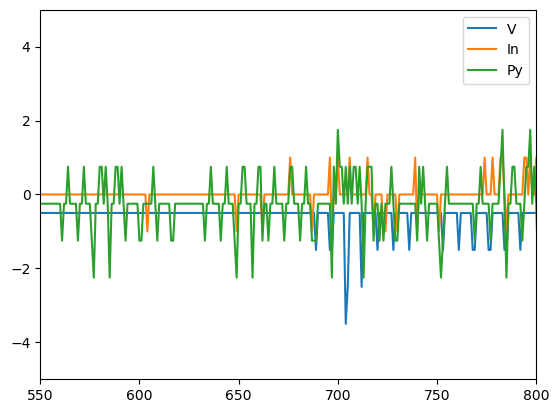

In [182]:
print(len(gauss_samps[0]))
print(len(verilog_data_decimated[Q_FACTOR][NOTCH][0]))
clocks = range(len(gauss_samps[0]))
plt.plot(clocks, verilog_data_decimated[Q_FACTOR][NOTCH][0]-0.5, label="V")
plt.plot(clocks, gauss_samps[0], label="In")
plt.plot(clocks, python_datas[0]-0.25, label="Py")
# plt.xlim(79000+300,79000+1000)
plt.xlim(550,800)
plt.ylim(-5,5)
plt.legend()
# plt.plot(clocks, verilog_data_decimated[Q_FACTOR][NOTCH][0])
plt.show()

In [195]:
TRIALS = 1
NOTCH = 800
Q_FACTOR = 8
verilog_nominal_latency = 144

b, a = signal.iirnotch(NOTCH,Q_FACTOR, 3000)

verilog_data = []
with open("001_files/outputs/verilog/pulse_output_height_512.dat", "r") as in_file:
    data = []
    for line in in_file:
        data.append(convert_from_fixed_point(int(int(line)), 12, 0))
        #L NEED TO FIND LATENCY, AND THEN APPLY FILTER NORMALLY FOR SAMPLES 2-7
    verilog_data = np.array(data[verilog_nominal_latency:],dtype=np.int64)
print(len(data))
pulse_run = import_data("001_files/inputs/pulse_input_height_512_clipped.dat")
pulse_original_samps = pulse_run.copy()
pulse_samps = pulse_run[:-verilog_nominal_latency].copy()
print(len(pulse_run))

coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(NOTCH,Q_FACTOR))

python_data_IIR = iir_biquad_run_fixed_point(pulse_original_samps.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)

python_data_FIR =np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],pulse_original_samps.copy())),dtype=np.int64)
python_data_zero_first = np.right_shift(iir_biquad_run_fixed_point(python_data_FIR.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) ,14)

python_data_trimmed = python_data[:-verilog_nominal_latency].copy()
python_data_zero_first_trimmed = python_data_zero_first[:-verilog_nominal_latency].copy()

lfilter_data = lfilter(b,a, pulse_original_samps.copy()) 
lfilter_data_trimmed = lfilter_data[:-verilog_nominal_latency].copy()

80064
80064


79920
79920
INVESTIGATE IIR ONLY BEHAVIOR


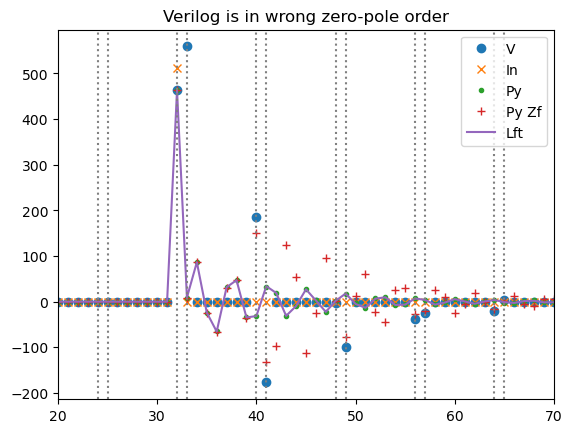

[0.90484619 0.18914795 0.90484619]
[1.         0.18914795 0.80975342]


In [196]:
print(len(python_data_trimmed))
print(len(verilog_data))
print("INVESTIGATE IIR ONLY BEHAVIOR")
clocks = range(len(pulse_samps))
plt.plot(clocks, verilog_data, linestyle="None", marker="o", label="V")
plt.plot(clocks, pulse_samps, linestyle="None", marker="x", label="In")
plt.plot(clocks, python_data_trimmed, linestyle="None", marker=".", label="Py")
plt.plot(clocks, python_data_zero_first_trimmed, linestyle="None", marker="+", label="Py Zf")
plt.plot(clocks, lfilter_data_trimmed, linestyle="-", label="Lft")
# plt.xlim(79000+300,79000+1000)
plt.xlim(20,70)
for i in range(40):
    plt.axvline(x=8*i, linestyle=":", color="grey")
    plt.axvline(x=8*i+1, linestyle=":", color="grey")
# plt.ylim(-5,5)
plt.legend()
# plt.plot(clocks, verilog_data_decimated[Q_FACTOR][NOTCH][0])
plt.title("Verilog is in wrong zero-pole order")
plt.show()
print(b_fixed_point_signed/(2**14))
print(a_fixed_point_signed/(2**14))

### Just IIR, b=[0,1,0]

In [316]:
TRIALS = 1
NOTCH = 800
Q_FACTOR = 8
verilog_nominal_latency = 144 + 0 # The +1 is for the latency added by the b=[0,1,0] numerator

b, a = signal.iirnotch(NOTCH,Q_FACTOR, 3000)

verilog_data = []
with open("001_files/outputs/verilog/no_zero_pulse_output_height_512.dat", "r") as in_file:
    data = []
    for line in in_file:
        data.append(convert_from_fixed_point(int(int(line)), 12, 0))
        #L NEED TO FIND LATENCY, AND THEN APPLY FILTER NORMALLY FOR SAMPLES 2-7
    verilog_data = np.array(data[verilog_nominal_latency:],dtype=np.int64)
print(len(data))
pulse_run = import_data("001_files/inputs/pulse_input_height_512_clipped.dat")
pulse_original_samps = pulse_run.copy()
pulse_samps = pulse_run[:-verilog_nominal_latency].copy()
print(len(pulse_run))

coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(NOTCH,Q_FACTOR))

python_data_IIR = iir_biquad_run_fixed_point(pulse_original_samps.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
python_data = np.right_shift(np.array(np.floor(lfilter(np.array([0,16384,0], dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)

python_data_FIR = np.array(np.floor(lfilter(np.array([0,16384,0], dtype=float),[1],pulse_original_samps.copy())),dtype=np.int64)
python_data_zero_first = np.right_shift(iir_biquad_run_fixed_point(python_data_FIR.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) ,14)

python_data_trimmed = python_data[:-verilog_nominal_latency].copy()
python_data_zero_first_trimmed = python_data_zero_first[:-verilog_nominal_latency].copy()

lfilter_data = lfilter([0,1,0],a, pulse_original_samps.copy()) 
lfilter_data_trimmed = lfilter_data[:-verilog_nominal_latency].copy()

80056
80064


In [317]:
FIR_OFFSET=1
USE_FIR = False
clipped_length = int(len(verilog_data)/8)*8
incremental_data = verilog_data.copy()[:clipped_length]
IIR_data = verilog_data.copy()[:clipped_length]
# FINISH IIR
# for clock in range(int(len(verilog_data)/8)):
#     for i in range(0,2):
#         idx = clock*8+i
#         if USE_FIR: # This is being applied to existing outputs
#             incremental_data[idx] = np.right_shift((b_fixed_point_signed[0]) * IIR_data[idx],14)
#             incremental_data[idx] += np.right_shift((b_fixed_point_signed[1]) * IIR_data[idx-1],14)
#             incremental_data[idx] += np.right_shift((b_fixed_point_signed[2]) * IIR_data[idx-2],14)
# # RUN FIR
#     for i in range(2,8):
#         idx = clock*8+i
#         if USE_FIR:
#             incremental_data[idx] += b_fixed_point_signed[0] * pulse_samps[idx-FIR_OFFSET]
#             incremental_data[idx] += b_fixed_point_signed[1] * pulse_samps[idx-1-FIR_OFFSET]
#             incremental_data[idx] += b_fixed_point_signed[2] * pulse_samps[idx-2-FIR_OFFSET]
#         incremental_data[idx] -= a_fixed_point_signed[1] * incremental_data[idx-1]
#         incremental_data[idx] -= a_fixed_point_signed[2] * incremental_data[idx-2]
#         incremental_data[idx] = np.right_shift(incremental_data[idx],14)


# FINISH IIR
for clock in range(int(len(verilog_data)/8)):
    for i in range(2,8):
        idx = clock*8+i
        incremental_data[idx] += 16384 * pulse_samps[idx-FIR_OFFSET]
        incremental_data[idx] -= a_fixed_point_signed[1] * incremental_data[idx-1]
        incremental_data[idx] -= a_fixed_point_signed[2] * incremental_data[idx-2]
        incremental_data[idx] = np.right_shift(incremental_data[idx],14)
# USE FIR
for clock in range(int(len(verilog_data)/8)):
    for i in range(0,8):
        idx = clock*8+i
        if USE_FIR: # This is being applied to existing outputs
            incremental_data[idx] = np.right_shift((b_fixed_point_signed[0]) * incremental_data[idx],14)
            incremental_data[idx] += np.right_shift((b_fixed_point_signed[1]) * incremental_data[idx-1],14)
            incremental_data[idx] += np.right_shift((b_fixed_point_signed[2]) * incremental_data[idx-2],14)

79920
79912


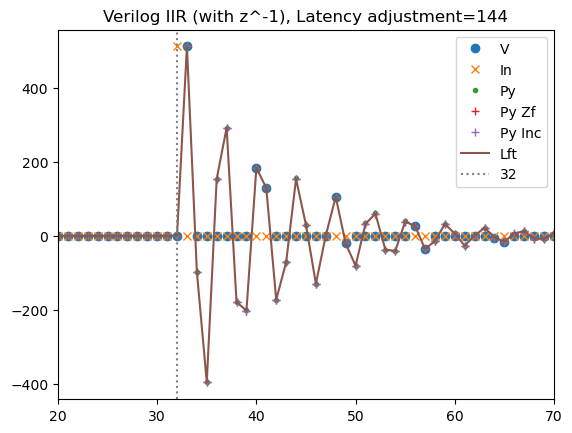

[0.90484619 0.18914795 0.90484619]
[1.         0.18914795 0.80975342]


In [318]:
print(len(python_data_trimmed))
print(len(verilog_data))
clocks = range(np.min([len(pulse_samps),len(verilog_data)]))
plt.plot(clocks, verilog_data[:len(clocks)], linestyle="None", marker="o", label="V")
plt.plot(clocks, pulse_samps[:len(clocks)], linestyle="None", marker="x", label="In")
plt.plot(clocks, python_data_trimmed[:len(clocks)], linestyle="None", marker=".", label="Py")
plt.plot(clocks, python_data_zero_first_trimmed[:len(clocks)], linestyle="None", marker="+", label="Py Zf")
plt.plot(clocks[:clipped_length], incremental_data, linestyle="None", marker="+", label="Py Inc")
plt.plot(clocks, lfilter_data_trimmed[:len(clocks)], linestyle="-", label="Lft")
plt.axvline(x=32, linestyle=":", color="grey", label="32")
# plt.xlim(79000+300,79000+1000)
plt.xlim(20,70)
# plt.ylim(-5,5)
plt.legend()
# plt.plot(clocks, verilog_data_decimated[Q_FACTOR][NOTCH][0])
plt.title("Verilog IIR (with z^-1), Latency adjustment=%s"%verilog_nominal_latency)
plt.show()
print(b_fixed_point_signed/(2**14))
print(a_fixed_point_signed/(2**14))

### Incremental Section (IIR Only) Applied In Python

In [314]:
FIR_OFFSET=1
USE_FIR = False
clipped_length = int(len(verilog_data)/8)*8
incremental_data = verilog_data.copy()[:clipped_length]
for clock in range(int(len(verilog_data)/8)):
    for i in range(2,8):
        idx = clock*8+i
        if USE_FIR:
            incremental_data[idx] += b_fixed_point_signed[0] * pulse_samps[idx-FIR_OFFSET]
            incremental_data[idx] += b_fixed_point_signed[1] * pulse_samps[idx-1-FIR_OFFSET]
            incremental_data[idx] += b_fixed_point_signed[2] * pulse_samps[idx-2-FIR_OFFSET]
        incremental_data[idx] -= a_fixed_point_signed[1] * incremental_data[idx-1]
        incremental_data[idx] -= a_fixed_point_signed[2] * incremental_data[idx-2]
        incremental_data[idx] = np.right_shift(incremental_data[idx],14)

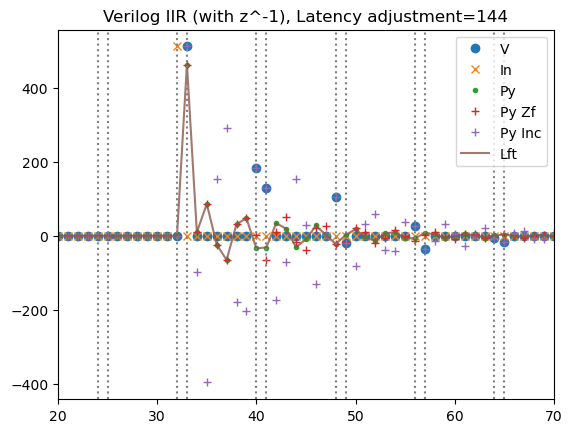

[0.90484619 0.18914795 0.90484619]
[1.         0.18914795 0.80975342]


In [315]:
clocks = range(len(pulse_samps))
clocks = range(np.min([len(pulse_samps),len(verilog_data)]))
plt.plot(clocks, verilog_data[:len(clocks)], linestyle="None", marker="o", label="V")
plt.plot(clocks, pulse_samps[:len(clocks)], linestyle="None", marker="x", label="In")
plt.plot(clocks, python_data_trimmed[:len(clocks)], linestyle="None", marker=".", label="Py")
plt.plot(clocks, python_data_zero_first_trimmed[:len(clocks)], linestyle="None", marker="+", label="Py Zf")
plt.plot(clocks[:clipped_length], incremental_data, linestyle="None", marker="+", label="Py Inc")
plt.plot(clocks, lfilter_data_trimmed[:len(clocks)], linestyle="-", label="Lft", alpha=0.8)
for i in range(40):
    plt.axvline(x=8*i, linestyle=":", color="grey")
    plt.axvline(x=8*i+1, linestyle=":", color="grey")
# plt.xlim(79000+300,79000+1000)
plt.xlim(20,70)
# plt.ylim(-5,5)
plt.legend()
# plt.plot(clocks, verilog_data_decimated[Q_FACTOR][NOTCH][0])
plt.title("Verilog IIR (with z^-1), Latency adjustment=%s"%verilog_nominal_latency)
plt.savefig("debug.png",dpi=500)
plt.show()
print(b_fixed_point_signed/(2**14))
print(a_fixed_point_signed/(2**14))


## Incremental Section (Full Biquad) Applied in Python

In [339]:
TRIALS = 1
NOTCH = 800
Q_FACTOR = 8
verilog_nominal_latency = 144 + 0 # The +1 is for the latency added by the b=[0,1,0] numerator

b, a = signal.iirnotch(NOTCH,Q_FACTOR, 3000)

verilog_data = []
with open("001_files/outputs/verilog/no_zero_pulse_output_height_512.dat", "r") as in_file:
    data = []
    for line in in_file:
        data.append(convert_from_fixed_point(int(int(line)), 12, 0))
        #L NEED TO FIND LATENCY, AND THEN APPLY FILTER NORMALLY FOR SAMPLES 2-7
    verilog_data = np.array(data[verilog_nominal_latency:],dtype=np.int64)
print(len(data))
pulse_run = import_data("001_files/inputs/pulse_input_height_512_clipped.dat")
pulse_original_samps = pulse_run.copy()
pulse_delayed_samps = lfilter([0,1,0], [1], np.array(pulse_run.copy(), dtype=float))
pulse_samps = pulse_run[:-verilog_nominal_latency].copy()
print(len(pulse_run))

coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(NOTCH,Q_FACTOR))

python_data_IIR = iir_biquad_run_fixed_point(pulse_delayed_samps.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)

python_data_FIR = np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],pulse_delayed_samps.copy())),dtype=np.int64)
python_data_zero_first = np.right_shift(iir_biquad_run_fixed_point(python_data_FIR.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) ,14)

python_data_trimmed = python_data[:-verilog_nominal_latency].copy()
python_data_zero_first_trimmed = python_data_zero_first[:-verilog_nominal_latency].copy()

lfilter_data = lfilter(b_fixed_point_signed/(2**14),a, pulse_delayed_samps.copy()) 
lfilter_data_trimmed = lfilter_data[:-verilog_nominal_latency].copy()

80056
80064


In [340]:
FIR_OFFSET=1
USE_FIR = True
clipped_length = int(len(verilog_data)/8)*8
incremental_data = verilog_data.copy()[:clipped_length]
IIR_data = verilog_data.copy()[:clipped_length]
# FINISH IIR
# for clock in range(int(len(verilog_data)/8)):
#     for i in range(0,2):
#         idx = clock*8+i
#         if USE_FIR: # This is being applied to existing outputs
#             incremental_data[idx] = np.right_shift((b_fixed_point_signed[0]) * IIR_data[idx],14)
#             incremental_data[idx] += np.right_shift((b_fixed_point_signed[1]) * IIR_data[idx-1],14)
#             incremental_data[idx] += np.right_shift((b_fixed_point_signed[2]) * IIR_data[idx-2],14)
# # RUN FIR
#     for i in range(2,8):
#         idx = clock*8+i
#         if USE_FIR:
#             incremental_data[idx] += b_fixed_point_signed[0] * pulse_samps[idx-FIR_OFFSET]
#             incremental_data[idx] += b_fixed_point_signed[1] * pulse_samps[idx-1-FIR_OFFSET]
#             incremental_data[idx] += b_fixed_point_signed[2] * pulse_samps[idx-2-FIR_OFFSET]
#         incremental_data[idx] -= a_fixed_point_signed[1] * incremental_data[idx-1]
#         incremental_data[idx] -= a_fixed_point_signed[2] * incremental_data[idx-2]
#         incremental_data[idx] = np.right_shift(incremental_data[idx],14)


# FINISH IIR
for clock in range(int(len(verilog_data)/8)):
    for i in range(2,8):
        idx = clock*8+i
        incremental_data[idx] += 16384 * pulse_samps[idx-FIR_OFFSET]
        incremental_data[idx] -= a_fixed_point_signed[1] * incremental_data[idx-1]
        incremental_data[idx] -= a_fixed_point_signed[2] * incremental_data[idx-2]
        incremental_data[idx] = np.right_shift(incremental_data[idx],14)
# USE FIR
incremental_before = incremental_data.copy()
for clock in range(int(len(verilog_data)/8)):
    for i in range(0,8):
        idx = clock*8+i
        if USE_FIR: # This is being applied to existing outputs
            incremental_data[idx] = int((b_fixed_point_signed[0]/(2**14)) * incremental_before[idx])
            incremental_data[idx] += int((b_fixed_point_signed[1]/(2**14)) * incremental_before[idx-1])
            incremental_data[idx] += int((b_fixed_point_signed[2]/(2**14)) * incremental_before[idx-2])

MAY BE DOUBLE COUNTING THE NUMERATOR, SUBTRACTED FROM ITERATIVE, SINCE B=[0,1,0] IS AREADY THERE


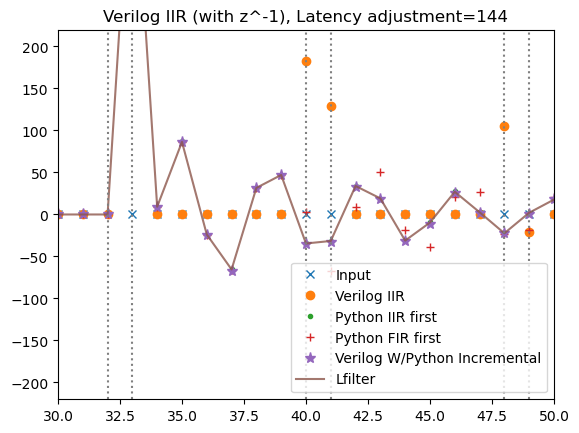

[ 0.99841309 -1.13970947  0.99841309]
[ 1.         -1.13970947  0.99688721]


In [357]:
clocks = range(len(pulse_samps))
clocks = range(np.min([len(pulse_samps),len(verilog_data)]))
plt.plot(clocks, pulse_samps[:len(clocks)], linestyle="None", marker="x", label="Input")
plt.plot(clocks, verilog_data[:len(clocks)], linestyle="None", marker="o", label="Verilog IIR")
plt.plot(clocks, python_data_trimmed[:len(clocks)], linestyle="None", marker=".", label="Python IIR first")
plt.plot(clocks, python_data_zero_first_trimmed[:len(clocks)], linestyle="None", marker="+", label="Python FIR first")
plt.plot(clocks[:clipped_length], incremental_data, linestyle="None", marker="*", markersize=8, label="Verilog W/Python Incremental")
plt.plot(clocks, lfilter_data_trimmed[:len(clocks)], linestyle="-", label="Lfilter", alpha=0.8)
for i in range(40):
    plt.axvline(x=8*i, linestyle=":", color="grey")
    plt.axvline(x=8*i+1, linestyle=":", color="grey")
plt.xlim(30,50)
plt.ylim(-220,220)
# plt.ylim(-1000,1000)
plt.legend()
# plt.plot(clocks, verilog_data_decimated[Q_FACTOR][NOTCH][0])
print("MAY BE DOUBLE COUNTING THE NUMERATOR, SUBTRACTED FROM ITERATIVE, SINCE B=[0,1,0] IS AREADY THERE")
plt.title("Verilog IIR (with z^-1), Latency adjustment=%s"%verilog_nominal_latency)
plt.savefig("debug.png",dpi=500)
plt.show()
print(b_fixed_point_signed/(2**14))
print(a_fixed_point_signed/(2**14))


### Testing on Gaussians

In [ ]:
TRIALS = 1
NOTCH = 800
Q_FACTOR = 8
verilog_nominal_latency = 144 + 0 # The +1 is for the latency added by the b=[0,1,0] numerator

b, a = signal.iirnotch(NOTCH,Q_FACTOR, 3000)

verilog_data = []
with open("001_files/outputs/verilog/no_zero_pulse_output_height_512.dat", "r") as in_file:
    data = []
    for line in in_file:
        data.append(convert_from_fixed_point(int(int(line)), 12, 0))
        #L NEED TO FIND LATENCY, AND THEN APPLY FILTER NORMALLY FOR SAMPLES 2-7
    verilog_data = np.array(data[verilog_nominal_latency:],dtype=np.int64)
print(len(data))
pulse_run = import_data("001_files/inputs/pulse_input_height_512_clipped.dat")
pulse_original_samps = pulse_run.copy()
pulse_delayed_samps = lfilter([0,1,0], [1], np.array(pulse_run.copy(), dtype=float))
pulse_samps = pulse_run[:-verilog_nominal_latency].copy()
print(len(pulse_run))

coeffs_fixed_point_signed, a_fixed_point_signed, b_fixed_point_signed = get_coeffs("001_files/coefficients/coeff_file_%sMHz_%s.dat"%(NOTCH,Q_FACTOR))

python_data_IIR = iir_biquad_run_fixed_point(pulse_delayed_samps.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)

python_data_FIR = np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],pulse_delayed_samps.copy())),dtype=np.int64)
python_data_zero_first = np.right_shift(iir_biquad_run_fixed_point(python_data_FIR.copy(), coeffs_fixed_point_signed, 
                                         decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) ,14)

python_data_trimmed = python_data[:-verilog_nominal_latency].copy()
python_data_zero_first_trimmed = python_data_zero_first[:-verilog_nominal_latency].copy()

lfilter_data = lfilter(b_fixed_point_signed/(2**14),a, pulse_delayed_samps.copy()) 
lfilter_data_trimmed = lfilter_data[:-verilog_nominal_latency].copy()

# Unfortunate Scratch

In [ ]:
fft_input_result = {}
fft_patrick_result = {}
fft_lfilter_result = {}
fft_python_result = {}

In [ ]:
TRIALS = 1000
ONLY_L = True
NOTCH_A = 375
Q_A =  # fq/bw

NOTCH_B = 460
Q_B = NOTCH_B / 50

# Get the parameters of the notch
b, a = signal.iirnotch(NOTCH_A, Q_A, 3000)
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
pmag=np.abs(pole)
pangle=np.angle(pole)
zmag=np.abs(zero)
zangle=np.angle(zero)

# Get the coefficients for the quantized biquad
coeffs = iir_biquad_coeffs(pmag, pangle)
coeffs_fixed_point = np.zeros(len(coeffs), dtype=np.int64)
coeffs_fixed_point_signed = np.zeros(len(coeffs), dtype=np.int64)
b_fixed_point_signed = np.zeros(len(b))
a_fixed_point_signed = np.zeros(len(a))

## Usual Fixed Point
# For transfer function numerator
for i in range(len(b)):
    b_fixed_point_signed[i] = np.floor(b[i] * (2**14))
b_fixed_point_signed = np.array(b_fixed_point_signed, dtype=np.int64)
# Just in case we want to compare these later
# For transfer function denominator, after look-ahead
for i in range(len(a)):
    a_fixed_point_signed[i] = np.floor(a[i] * (2**14))
a_fixed_point_signed = np.array(a_fixed_point_signed, dtype=np.int64)
#  For clustered look-ahead
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point_signed[i] = np.floor(coeffs[i] * (2**14))

coeffs_fixed_point_signed = np.array(coeffs_fixed_point_signed, dtype=np.int64)

# Import the Gaussian input data once to get the lengths
data_len = len(import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%0))
fft_input_results = np.zeros((TRIALS, data_len))     
fft_patrick_results = np.zeros((TRIALS, data_len))     
fft_python_results = np.zeros((TRIALS, data_len))   
fft_lfilter_results = np.zeros((TRIALS, data_len))

# Run the trials on the data
for i in range(TRIALS):
    # Import the trial inputs
    gauss_samps = import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%i)

    lfilter_data = lfilter(b,a,gauss_samps.copy())
    # Run the filters on the trials
    if not ONLY_L:
        patrick_data = lfilter(b,[1],patrick_biquad(gauss_samps.copy(), 8, pmag, pangle, ics = None))
    
    
        python_data_IIR = iir_biquad_run_fixed_point(gauss_samps.copy(), coeffs_fixed_point_signed, 
                                             decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
        python_data = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR.copy())),dtype=np.int64),14)
    
        # # The "a"s being used are not quantized, they are processed as floating point
        # python_data_iir = iir_biquad_run_fixed_point(gauss_samps.copy(), coeffs_fixed_point_signed, 
        #                                          decimate=False, a1=a[1], a2=a[2],debug=0) 
    
        
        # # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
        # python_data = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed, [1], python_data_iir)),dtype=np.int64),14)
        
        fft_input_results[i] = np.abs(np.fft.fft(gauss_samps))**2   
        fft_patrick_results[i] = np.abs(np.fft.fft(patrick_data))**2
        fft_python_results[i] = np.abs(np.fft.fft(python_data))**2
    fft_lfilter_results[i] = np.abs(np.fft.fft(lfilter_data))**2
    if(i%10 == 0):
        print(i)


# Get the parameters of the notch
b, a = signal.iirnotch(NOTCH_B, Q_B, 3000)
pole = signal.tf2zpk(b,a)[1][0]
zero = signal.tf2zpk(b,a)[0][0]
pmag=np.abs(pole)
pangle=np.angle(pole)
zmag=np.abs(zero)
zangle=np.angle(zero)

# Get the coefficients for the quantized biquad
coeffs = iir_biquad_coeffs(pmag, pangle)
coeffs_fixed_point = np.zeros(len(coeffs), dtype=np.int64)
coeffs_fixed_point_signed = np.zeros(len(coeffs), dtype=np.int64)
b_fixed_point_signed = np.zeros(len(b))
a_fixed_point_signed = np.zeros(len(a))

## Usual Fixed Point
# For transfer function numerator
for i in range(len(b)):
    b_fixed_point_signed[i] = np.floor(b[i] * (2**14))
b_fixed_point_signed = np.array(b_fixed_point_signed, dtype=np.int64)
# Just in case we want to compare these later
# For transfer function denominator, after look-ahead
for i in range(len(a)):
    a_fixed_point_signed[i] = np.floor(a[i] * (2**14))
a_fixed_point_signed = np.array(a_fixed_point_signed, dtype=np.int64)
#  For clustered look-ahead
for i in range(len(coeffs_fixed_point)):
    # Coefficients are in Q4.14, where the sign bit IS counted
    coeffs_fixed_point_signed[i] = np.floor(coeffs[i] * (2**14))

coeffs_fixed_point_signed = np.array(coeffs_fixed_point_signed, dtype=np.int64)

# Import the Gaussian input data once to get the lengths
data_len = len(import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%0))
fft_input_results2 = np.zeros((TRIALS, data_len))     
fft_patrick_results2 = np.zeros((TRIALS, data_len))     
fft_python_results2 = np.zeros((TRIALS, data_len))   
fft_lfilter_results2 = np.zeros((TRIALS, data_len))

# Run the trials on the data
for i in range(TRIALS):
    # Import the trial inputs
    # gauss_samps = import_data("001_files/inputs/gauss_input_400_sigma_hanning_clipped_%d.dat"%i)

    lfilter_data_2 = lfilter(b,a,lfilter_data.copy())
    # Run the filters on the trials
    if not ONLY_L:

        patrick_data_2 = lfilter(b,[1],patrick_biquad(patrick_data.copy(), 8, pmag, pangle, ics = None))
        python_data_IIR_2 = iir_biquad_run_fixed_point(python_data.copy(), coeffs_fixed_point_signed, 
                                             decimate=False, a1=a_fixed_point_signed[1], a2=a_fixed_point_signed[2],debug=DEBUG) 
        python_data_2 = np.right_shift(np.array(np.floor(lfilter(np.array(b_fixed_point_signed, dtype=float),[1],python_data_IIR_2.copy())),dtype=np.int64),14)
    
        # # The "a"s being used are not quantized, they are processed as floating point
        # python_data_iir = iir_biquad_run_fixed_point(gauss_samps.copy(), coeffs_fixed_point_signed, 
        #                                          decimate=False, a1=a[1], a2=a[2],debug=0) 
    
        
        # # Apply the numerator with lfilter, the rest of the "junk" is correcting for multiplying a fixed point value
        # python_data = np.right_shift(np.array(np.round(signal.lfilter(b_fixed_point_signed, [1], python_data_iir)),dtype=np.int64),14)
  
        fft_patrick_results2[i] = np.abs(np.fft.fft(patrick_data_2))**2
        fft_python_results2[i] = np.abs(np.fft.fft(python_data_2))**2
    fft_lfilter_results2[i] = np.abs(np.fft.fft(lfilter_data_2))**2        
    fft_input_results2[i] = np.abs(np.fft.fft(gauss_samps))**2 
    if(i%10 == 0):
        print(i)



fft_lfilter_result[NOTCH_A + 10000*NOTCH_B] = np.mean(fft_lfilter_results2, axis=0)
fft_input_result[NOTCH_A + 10000*NOTCH_B] = np.mean(fft_input_results2, axis=0)
if not ONLY_L:
    fft_patrick_result[NOTCH_A + 10000*NOTCH_B] = np.mean(fft_patrick_results2, axis=0)
    fft_python_result[NOTCH_A + 10000*NOTCH_B] = np.mean(fft_python_results2, axis=0)

In [ ]:
plot_notch_freq_a = 375
plot_notch_freq_b = 460
plot_notch_freq = plot_notch_freq_a + 10000*plot_notch_freq_b
plt.plot(np.fft.fftfreq(len(fft_input_result[plot_notch_freq])),np.abs(fft_input_result[plot_notch_freq]), linestyle="None", 
         marker=".", label="input", markersize=5, alpha=0.9, color="C0")
plt.plot(np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq]), linestyle="None", 
         marker=".", label="floating point with CLA", markersize=5, alpha=0.9, color="C1")
plt.plot(np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq])),np.abs(fft_lfilter_result[plot_notch_freq]), linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.9, color="C2")
plt.plot(np.fft.fftfreq(len(fft_python_result[plot_notch_freq])),np.abs(fft_python_result[plot_notch_freq]), linestyle="None",
         marker=".", label="python", markersize=5, alpha=0.9, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**8)
plt.title("Gaussian noise in filters")
# plt.xlim(0,0.5)
# plt.savefig("GaussianNoiseOn%dMHzNotch.png"%plot_notch_freq)
plt.show()

mean_power = np.mean(fft_input_result[plot_notch_freq])


plt.plot(np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq])/mean_power, linestyle="None", 
         marker=".", label="floating point with CLA", markersize=5, alpha=0.9, color="C1")
plt.plot(np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq])),np.abs(fft_lfilter_result[plot_notch_freq])/mean_power, linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.9, color="C2")
plt.plot(np.fft.fftfreq(len(fft_python_result[plot_notch_freq])),np.abs(fft_python_result[plot_notch_freq])/mean_power, linestyle="None",
         marker=".", label="python", markersize=5, alpha=0.9, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**-5)
plt.title("Gaussian noise in filters")
plt.xlim(0,0.5)
plt.xlabel("Frequency/(Sampling Frequency)")
plt.ylabel("Gain")
# plt.savefig("GaussianNoiseOn%dMHzNotch.png"%plot_notch_freq)
plt.show()

In [ ]:
plot_notch_freq_a = 375
plot_notch_freq_b = 460
plot_notch_freq = plot_notch_freq_a + 10000*plot_notch_freq_b
N=31
print(np.ceil(N/2.0))
# plt.plot(np.fft.fftfreq(len(fft_input_result[plot_notch_freq])),np.abs(fft_input_result[plot_notch_freq]), linestyle="None", 
#          marker=".", label="input", markersize=5, alpha=0.9, color="C0")
# plt.plot(np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq]), linestyle="None", 
#          marker=".", label="floating point with CLA", markersize=5, alpha=0.9, color="C1")
plt.plot(np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq]))[int(np.floor(N/2.0)):int(-np.floor(N/2.0))],np.convolve(np.abs(fft_lfilter_result[plot_notch_freq]), np.ones(N)/N, mode='valid'), linestyle="None",
         marker=".", label="lfilter", markersize=5, alpha=0.9, color="C2")
# plt.plot(np.fft.fftfreq(len(fft_python_result[plot_notch_freq])),np.abs(fft_python_result[plot_notch_freq]), linestyle="None",
#          marker=".", label="python", markersize=5, alpha=0.9, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**4)
plt.title("375 and 460 MHz Notches, BW of 50 MHz")
plt.xlim(0,0.5)
plt.savefig("DoubleNotchPlot.png")
plt.show()

print(fft_input_result[plot_notch_freq])
mean_power = np.mean(fft_input_result[plot_notch_freq])


# plt.plot(np.fft.fftfreq(len(fft_patrick_result[plot_notch_freq])),np.abs(fft_patrick_result[plot_notch_freq])/mean_power, linestyle="None", 
#          marker=".", label="floating point with CLA", markersize=5, alpha=0.9, color="C1")
plt.plot(np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq]))[int(np.floor(N/2.0)):int(-np.floor(N/2.0))],
        np.convolve(np.abs(fft_lfilter_result[plot_notch_freq]), np.ones(N)/N, mode='valid')/mean_power, linestyle="None",
        marker=".", label="lfilter", markersize=5, alpha=0.9, color="C2")
# plt.plot(np.fft.fftfreq(len(fft_python_result[plot_notch_freq])),np.abs(fft_python_result[plot_notch_freq])/mean_power, linestyle="None",
#          marker=".", label="python", markersize=5, alpha=0.9, color="C3")
plt.legend()
plt.yscale("log")
plt.gca().set_ylim(bottom=10**-5)
plt.title("375 and 460 MHz Notches, BW of 50 MHz")
plt.xlim(0,0.5)
plt.xlabel("Frequency/(Sampling Frequency)")
plt.ylabel("Gain")
plt.savefig("DoubleNotchPlot2.png")
plt.show()

In [ ]:
fft_points = np.fft.fftfreq(len(fft_lfilter_result[plot_notch_freq]))[int(np.floor(N/2.0)):int(-np.floor(N/2.0))]

In [ ]:
fft_points[1] - fft_points[0]

In [ ]:
fft_points[10001] - fft_points[10000]